# Differential Expression Visualizations

In [1]:
# install dependencies
if (!require("DESeq2")) {
    if (!require("BiocManager")) install.packages("BiocManager")
    library(BiocManager)
    BiocManager::install("DESeq2")
}
if (!require("tidyverse")) install.packages("tidyverse")
if (!require("pheatmap")) install.packages("pheatmap")

Loading required package: DESeq2

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min



At

In [2]:
# import dependencies
library("DESeq2")
library("pheatmap")
library("tidyverse")

## Data input + manipulation

DESeq2's vignette recommends reading in featureCount's count data and experimental design data (called column data in DESeq2's vignette) using generic functions. featureCount's count data rows are genes, columns 1 + 2 are gene ID and gene name, and the remaining columns are samples; each cell is an observed count. 

Each sample's laboratory ID will be used as the count data columns and the experimental design rows. The raw featureCount's count data table needs to be converted from using read file names (which are derived from TAGC's sample IDs) to using laboratory IDs. TAGC's provided keytable contains their sample ID and its corresponding laboratory ID for each sample. The laboratory ID is contained after the third `-` in the `Description` column. A regular expression is used to capture the laboratory ID and add it to `key`.

The laboratory ID from `key` is then used to transform the column names of the `featureCount` count matrix into their corresponding laboratory ID. To do this, I first elongate the data with `pivot_longer`, capturing gene column names into a single "sample" column and count values into a single "value" column. I then transform these column names to the shortened "Sample_ID" form via mutate, string extract, and a regular expression. I then join onto the key table on "Sample_ID" to attach the laboratory ID. Finally, I pivot back to the original wide format using `pivot_wider` with the "Lab ID" and "value" columns.

DESeq2 specifically requires columns of the count data be in the same order as the rows of the experimental design data. To do this for the count data, I use the `select` dplyr function to pick the first two columns I want in the transformed table, then pick all others by sorting their column names. For the experimental design data, I use the `arrange` function to perform the sort.

In [3]:
prepare_data = function(cts_path, key_path, exp_path) {
    # cts_path = a featureCounts output counts .tsv file
    # key_path = a TAGC keytable file
    # exp_path = an experimental design .tsv file

    # read in raw data
    key_raw = read_tsv(key_path)
    cts_raw = read_tsv(cts_path)
    exp_raw = read_tsv(exp_path)

    # regex patterns...
    labid_regex_pattern = "[^-]+$" # laboratory ID from `Description` in key table
    sampleid_regex_pattern = "^[^_]+" # sample ID from column names in cts table

    # perform data transformations
    key_tbl = key_raw %>% 
        mutate(Lab_ID = str_extract(Description, labid_regex_pattern))

    cts_tbl = cts_raw %>% 
        pivot_longer(cols = !c(Geneid, gene_name), names_to = "sample", values_to = "value") %>%
        mutate(Sample_ID = str_extract(sample, pattern = sampleid_regex_pattern)) %>%
        left_join(key_tbl, by = "Sample_ID") %>%
        pivot_wider(id_cols = c(Geneid, gene_name), names_from = Lab_ID, values_from = value) %>%
        select(Geneid, gene_name, sort(colnames(.)))

    exp_tbl = exp_raw %>% arrange(`SampleID-Lab`)

    # test that column + row count and sorts match
    sample_order_equal = all.equal(
        cts_tbl %>% select(-Geneid,-gene_name) %>% colnames(),
        exp_tbl %>% pull(`SampleID-Lab`)
    )
    stopifnot(sample_order_equal)
    
    return( list(cts_tbl,exp_tbl) )
    
}

In [4]:
# process data from the H358 experiment as an example

# paths to data
exp_path = "20210209_experiment_design_H358.tsv"
key_path = "keytables/H358_keytable.txt" # TAGC's provided keytable
cts_path = "featureCounts/runs_20210209-results_featureCounts_merged_gene_counts.txt" # Output from one experiment

# data prep
dat_prp = prepare_data(cts_path, key_path, exp_path)
cts_tbl = dat_prp[[1]]
exp_tbl = dat_prp[[2]]

# quick visual preview
cts_tbl %>% head() %>% select(1:7)
exp_tbl %>% head()


── Column specification ────────────────────────────────────────────────────────
cols(
  Sample_ID = col_character(),
  Description = col_character()
)



── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  Geneid = col_character(),
  gene_name = col_character()
)
ℹ Use `spec()` for the full column specifications.



── Column specification ────────────────────────────────────────────────────────
cols(
  `SampleID-Lab` = col_character(),
  `Cell Line` = col_double(),
  `Inhibition Status` = col_character(),
  CRISPR = col_character(),
  MRTX = col_logical(),
  BI = col_logical(),
  SHP2i = col_logical(),
  `Time Point` = col_double(),
  Population = col_character()
)




Geneid,gene_name,ES58NTMB01,ES58NTMB02,ES58NTMB03,ES58NTMB04,ES58NTMB05
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000223972,DDX11L1,3,0,0,0,0
ENSG00000227232,WASH7P,258,282,252,167,236
ENSG00000243485,MIR1302-10,0,0,0,0,0
ENSG00000237613,FAM138A,0,0,0,0,0
ENSG00000268020,OR4G4P,0,0,0,0,0
ENSG00000240361,OR4G11P,0,0,0,0,0


SampleID-Lab,Cell Line,Inhibition Status,CRISPR,MRTX,BI,SHP2i,Time Point,Population
<chr>,<dbl>,<chr>,<chr>,<lgl>,<lgl>,<lgl>,<dbl>,<chr>
ES58NTMB01,58,NTMB,NT,TRUE,TRUE,FALSE,6,A
ES58NTMB02,58,NTMB,NT,TRUE,TRUE,FALSE,6,A
ES58NTMB03,58,NTMB,NT,TRUE,TRUE,FALSE,6,B
ES58NTMB04,58,NTMB,NT,TRUE,TRUE,FALSE,6,B
ES58NTMB05,58,NTMB,NT,TRUE,TRUE,FALSE,72,A
ES58NTMB06,58,NTMB,NT,TRUE,TRUE,FALSE,72,A


## Visualize Tables for Specific Gene Sets

You probably have some gene sets that you expect to be differentially expressed. You can perform a sanity check by looking at the un-normalized count data for these genes.

In [5]:
select_genes = function(genes_path, cts_tbl) {
    # genes_path = path to plain text line containing one gene per line
    # cts_tbl = a processed featureCounts tibble object
    
    # left join cts_tbl with the gene set to see only the gene set
    genes_raw = read_tsv(genes_path, col_names = "gene_name")
    genes_tbl = genes_raw %>% left_join(cts_tbl, by = "gene_name")
    
    return( genes_tbl )
    
}

### ALDH Gene Set

In [6]:
# isolate table of genes from ALDH gene set
aldh_path = "Gene-lists/ALDH genes.txt"
aldh_tbl = select_genes(aldh_path, cts_tbl)

# quick visual preview
aldh_tbl %>% select(1:7)


── Column specification ────────────────────────────────────────────────────────
cols(
  gene_name = col_character()
)




gene_name,Geneid,ES58NTMB01,ES58NTMB02,ES58NTMB03,ES58NTMB04,ES58NTMB05
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ALDH1A1,ENSG00000165092,7,6,4,4,14
ALDH1A2,ENSG00000128918,13,4,30,28,21
ALDH1A3,ENSG00000184254,7452,8153,7728,5261,8051
ALDH1B1,ENSG00000137124,2054,1872,1957,1521,1205
ALDH1L1,ENSG00000144908,574,623,616,475,433
ALDH1L2,ENSG00000136010,55,39,71,93,39
ALDH2,ENSG00000111275,80,66,111,100,80
ALDH3A1,ENSG00000108602,2246,2427,2179,1391,345
ALDH3A2,ENSG00000072210,10738,10506,10967,7618,12026


## Convert to Matricies + Create DESeq2 Object

DESeq2 requires input as matrices; the following function performs this conversion, then reads in the matricies as a `dds` object, and performs estimation of size factors on the raw count data.

In [7]:
create_dds = function(cts_tbl, exp_tbl, design) {
    # cts_tbl = a processed featureCounts tibble object
    # exp_tbl = a processed experimental design tibble object

    # convert tibbles to matrices
    cts_mtx = cts_tbl %>%
        select(-gene_name) %>%
        column_to_rownames("Geneid") %>%
        rename_with(make.names) %>% # convert to base R matrix friendly names
        as.matrix()

    exp_mtx = exp_tbl %>%
        column_to_rownames("SampleID-Lab") %>%
        rename_with(make.names) %>%
        as.matrix()

    # create deseq2 object and apply size factor estimation
    # apply size factor estimation since we're coming from raw counts
    dds = DESeqDataSetFromMatrix(
        countData = cts_mtx,
        colData = exp_mtx,
        design = design
    ) %>% estimateSizeFactors()
     
    return( dds )
     
}

In [8]:
# create dds object from count and experimental design tbls then inspect
design = ~ CRISPR + Time.Point
dds = create_dds(cts_tbl, exp_tbl, design)
dds

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not an warning or error]

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not an warning or error]



class: DESeqDataSet 
dim: 63677 59 
metadata(1): version
assays(1): counts
rownames(63677): ENSG00000223972 ENSG00000227232 ... ENSG00000231514
  ENSG00000235857
rowData names(0):
colnames(59): ES58NTMB01 ES58NTMB02 ... ES58S2XX03 ES58S2XX04
colData names(9): Cell.Line Inhibition.Status ... Population sizeFactor

## Count Data Transformations + Quality Assessment Plots

DESeq2 recommends creation of data quality assessment plots in conjunction with, or prior to, differential expression analysis. These plots don't model the data, and could be called "unsupervised clustering" approaches.

The purpose of these plots is to visualize if the count data conforms to some basic expectations based on the experimental design. Do experimental replicates group together? Do the principle components express the expected sources of variation in the data? Do normalized counts show some hypothesized patterns? 

The DESeq2 vignette produces 3 plots: 

1) a count matrix heatmap (to see patterns across normalized counts)  
2) a sample distance heatmap (to see between sample clustering)  
3) a PCA (to see sample clustering + sources of variation)  

While the model that DESeq2 uses to assess differential expression already accounts for count data transformation / normalization, these "unsupervised clustering" approaches need the count data transformed manually prior to plotting, so this needs to be done first.

Note: Producing the first two plots requires a little data munging on the dds object, while the PCA is straightforward and doesn't need it's own function.

### Count Data Transformation

The DESeq2 vignette shows 3 different transformation functions, which transform the counts contained in the dds object. For the sake of example I show the `vst` transformation because it runs fast on a dataset this large, but other guides more strongly suggest using `rlog`. If you look at the DESeq2 vignette they're similar in their output, but you may want to switch to `rlog`.

In [9]:
vsd = vst(dds, blind = TRUE)

### Count Matrix Heatmap

To produce the count matrix heatmap, DESeq2's vignette pulls all necessary data out of the dds objects. The function below also allows you to filter by an existing gene table or by the top number of genes by greatest mean normalized expression.

In [10]:
plot_count_matrix_heatmap = function(
    dds, 
    dds_trans, 
    interesting_groups, 
    genes_table = NA,
    genes_number = NA
) {
    # dds = DESeq2 object
    # dds_trans = DESeq2 object with count transformation
    # design_vector = vector of experimental design factors of interest
    # genes_table = tbl of genes to filter count heatmap by
    # genes_number = number of genes to include in count heatmap 
    
    # get data from dds object
    df = colData(dds) %>%
        .[,interesting_groups] %>% 
        as.data.frame()
    nrm_cts_mtx = counts(dds, normalized = TRUE)
    
    # calculate mean normalized expression, then sort by it
    select = nrm_cts_mtx %>% 
        rowMeans() %>% 
        order(decreasing = TRUE)
    
    # filter by genes table, if provided
    if ( !all(genes_table %>% is.na()) ) {
        genes = pull(genes_table, "Geneid")
        genes_pos = which(row.names(nrm_cts_mtx) %in% genes)
        select = select[genes_pos]
    }
    
    # select top number of genes, if provided
    if ( !genes_number %>% is.na() ) {
        select = select[1:genes_number]
    }

    # make plots
    count_heatmap_unclustered = pheatmap(
        assay(dds_trans)[select,],
        cluster_rows = FALSE,
        show_rownames = TRUE,
        cluster_cols = FALSE,
        annotation_col = df,
        color = colorRampPalette(c("red", "white", "blue"))(100),
        main = "Count Matrix Heatmap, Unclustered"
    )
    count_heatmap_clustered = pheatmap(
        assay(dds_trans)[select,],
        cluster_rows = FALSE,
        show_rownames = TRUE,
        cluster_cols = TRUE,
        annotation_col = df,
        color = colorRampPalette(c("red", "white", "blue"))(100),
        main = "Count Matrix Heatmap, Clustered"
    )
    
}

In [11]:
plot_sample_distance_heatmap = function(dds_trans) {
    # dds_trans = DESeq2 object with count transformation

    # calculate distances from dds
    sampleDists = assay(dds_trans) %>% t() %>% dist()
    sampleDistMatrix = sampleDists %>% as.matrix()
    rownames(sampleDistMatrix)
    colnames(sampleDistMatrix)

    # make plot
    dist_heatmap = pheatmap(
        sampleDistMatrix,
        clustering_distance_rows = sampleDists,
        clustering_distance_cols = sampleDists,
        main = "Sample Distance Heatmap"
    )
    
}

In [12]:
# define the interesting experimental design groups for the plots below
interesting_groups = c("CRISPR","Time.Point")

#### Overall Count Data Heatmap

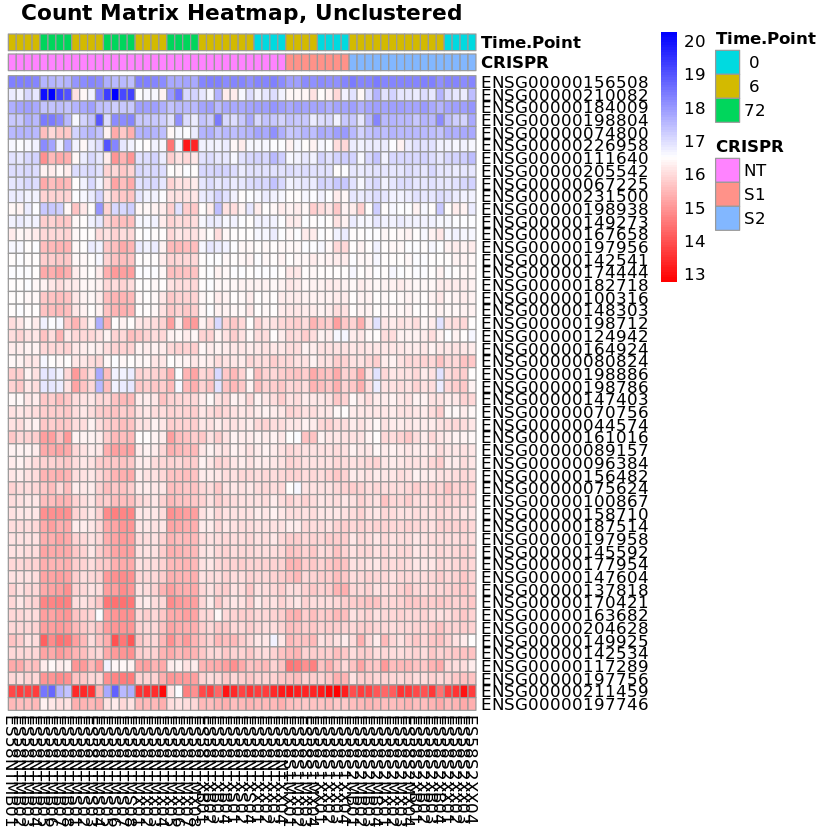

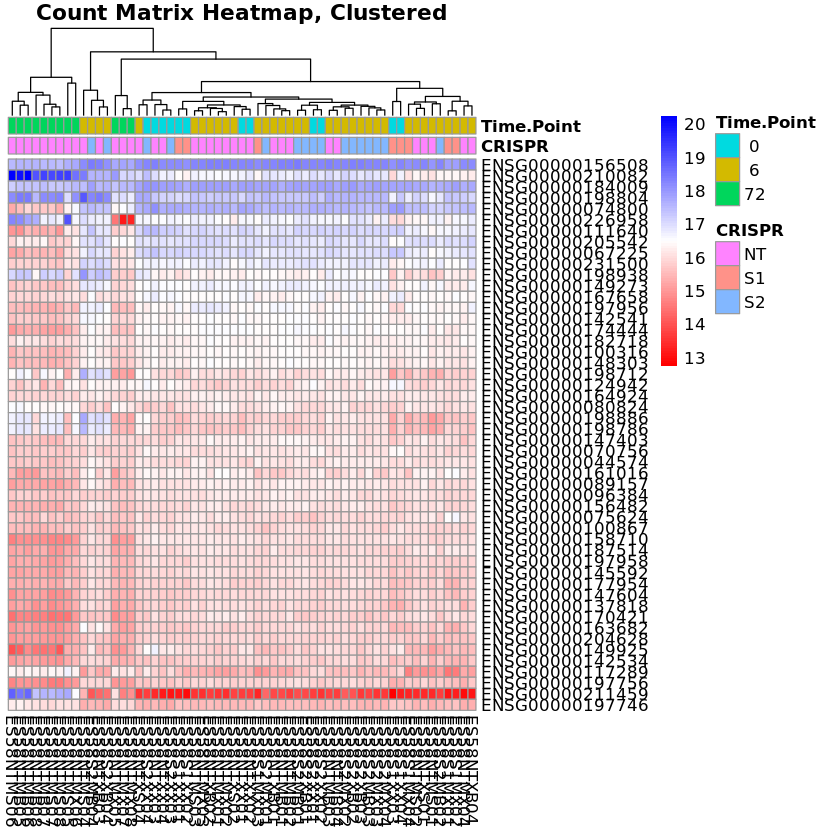

In [13]:
plot_count_matrix_heatmap(
    dds, 
    vsd, 
    interesting_groups, 
    genes_number = 50
)

#### ALDH Gene Set Count Data Heatmap

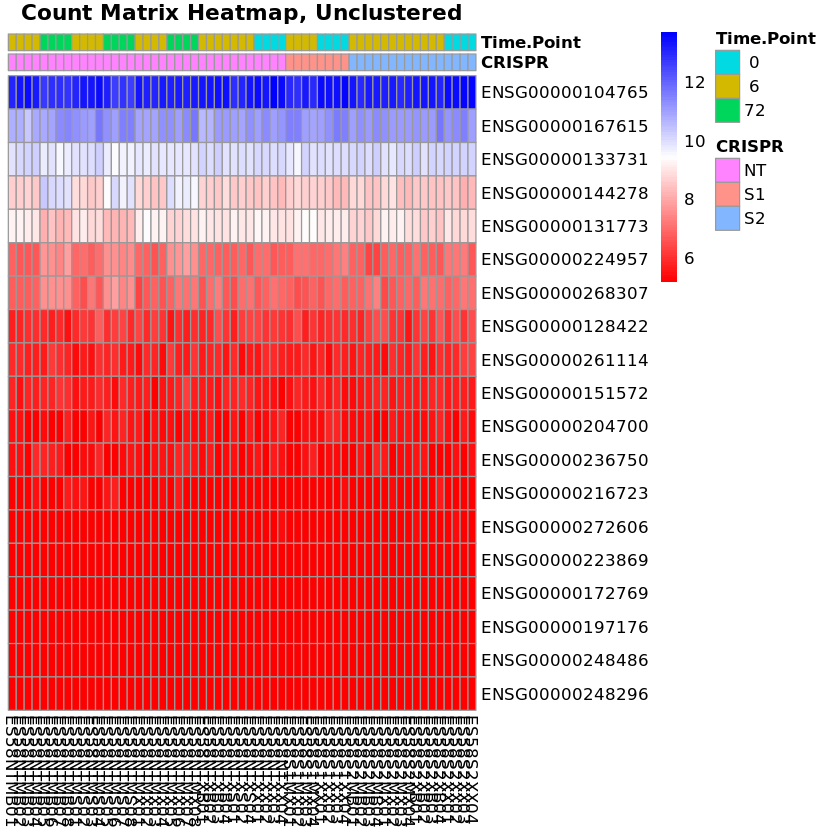

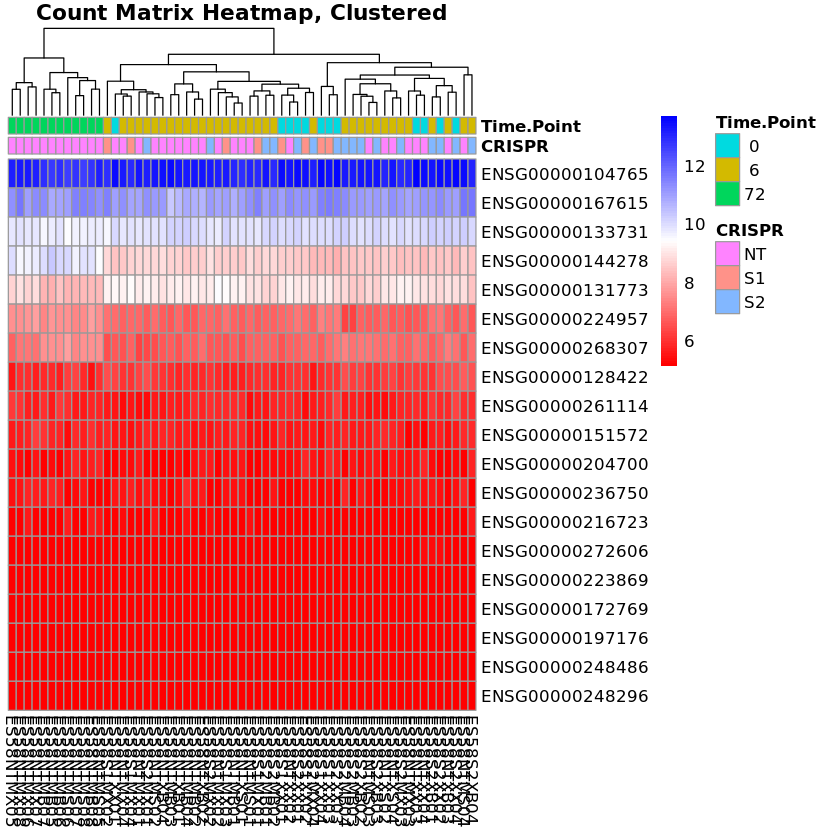

In [14]:
plot_count_matrix_heatmap(
    dds, 
    vsd, 
    interesting_groups, 
    genes_table = aldh_tbl
)

### Sample Distance Heatmap

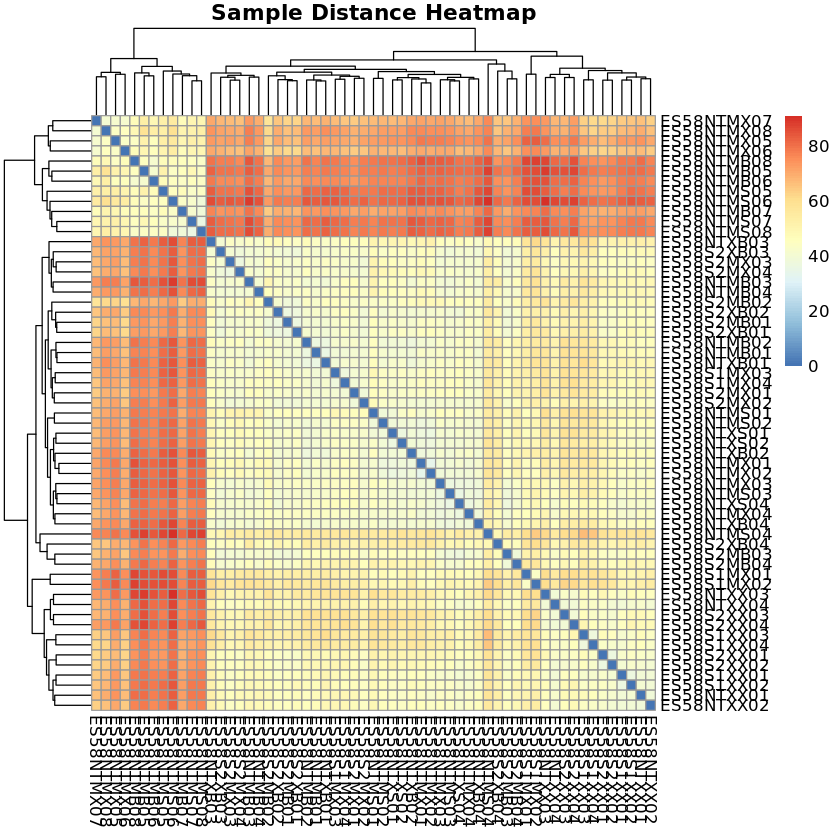

In [15]:
plot_sample_distance_heatmap(vsd)

### Principle Components Analysis

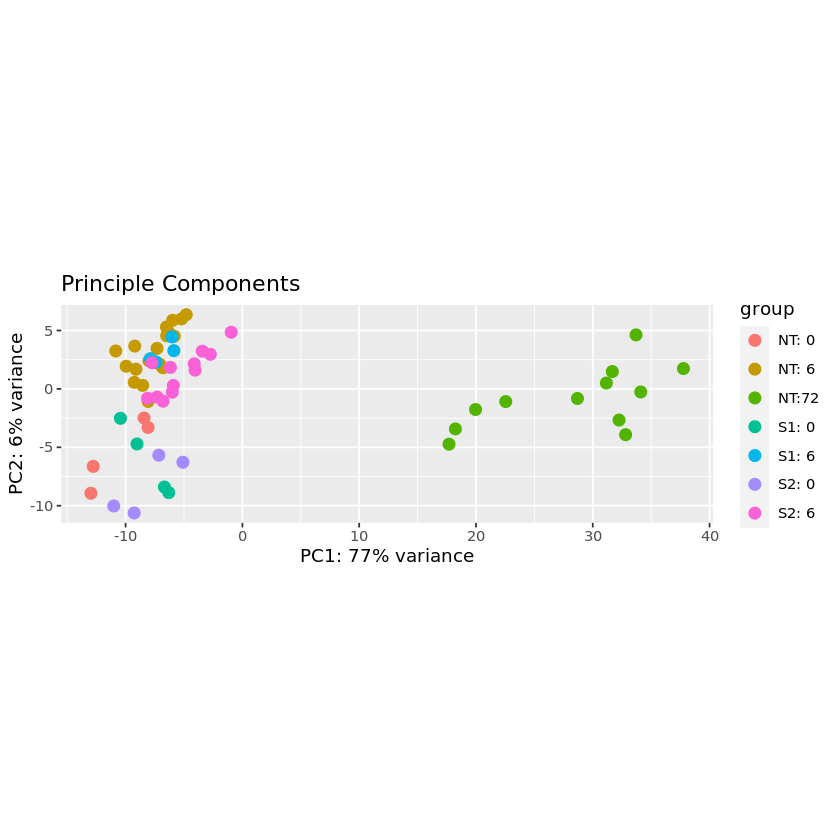

In [16]:
# DESeq2 uses ggplot2 here, so use ggtitle for the plot title
plotPCA(vsd, intgroup = interesting_groups) + ggtitle("Principle Components")